# Go Fund Me Campaign Analysis
----

This dataset comes from my scrape of selective go fund me queries. Selective in the fact that I was searching for campaigns for those diagnosed with COVID. This is not a full population but a sample. Go Fund Me would only serve me 1,000 results per query.

So my question is:

* Can I use this data because it is not comprehensive?
* If so, how do I talk about it?
* If not, I'd like to decide that now and pivot to focusing on to Story Idea B: The Cost of COVID in New York, a cost comparison analysis of the hospitals in NYC.

### To Do's
- This data also needs some cleaning, to filter out any non-Covid related posts that may have snuck in.
- I need to hone in on the story I want to tell


### My story

My focus will be on hospital stays. I can use regex to try to pull out days or weeks for as many campaigns as I can and write about what I found. Once I clean the data, I would like to try to compare the goals of gofundme campaigns with the length of the hospital stay. I'd like to look closer at the descriptions and see if I can draw out any more insightful information about their experiences.

Given that I have chargemaster data, and codes related to COVID stays, I would like to pick a few of the common codes, like ICU stay or 96+ hours on a ventilator, etc, and provide mean charges for those.

The challenge will be the comparison. Can I select a few hospitals in some of the major areas rerpesented in this dataset? That feels like shaky comparison. Perhaps I can't include that at all?


In [528]:
# Gotta remove list

to_remove = [47677154,47135376,47141460, 47661346,47492412,47029974,46462466,46346152,46998808,46263652,46400668,46940542,46987730,46285602,47035396,51591180, 48472462,58726947,61404791,62912673,55386132,59372949,58173395,54652018,54572372,62141755,61429443,48586356,53304724,51934796,62542249,43764678,48182442,51897366,48778438,57393727,55770764,56473763,61174051]

In [495]:
import pandas as pd
import re

In [530]:
 df = df[~df.id.isin(to_remove)]

In [478]:
df[df.description.str.contains("small business", case=False)].description.to_list()

["\n<p>My dad contracted COVID-19 on December 14, 2020, and he's coming home on July 3rd. As a family, we are ecstatic that he is coming back home after being in the hospital for 6 months. With a virus as deadly as COVID-19, we were unsure this would be happening for us. I'm here today to share my dad's story and our current dilemma.\n</p>\n\n<p>\xa0\n</p>\n\n<p>From a very early age, Miguel knew he was good at being a salesman. While other kids had dreams of becoming doctors or lawyers, he knew he wanted to own a small business. He married his high school sweetheart on a whim and rapidly began working to provide for his growing family. Miguel eventually landed a job at Pan American in Edinburg, Texas. It was there where his boss took him under his wings and taught him the ins and outs of running a business. In 1982 Miguel took that knowledge and started United Restaurant Supply. With a mere $700, he began selling kitchenware out of his garage and at local flea markets. Miguel would ev

In [493]:
df[df.name.str.contains("business", case=False)].id.to_list()

[55195340,
 61851291,
 47810910,
 53341232,
 62912673,
 55386132,
 59372949,
 58173395,
 54652018,
 54572372,
 62365911]

### Merge my two campaign scrapes & drop duplicates

In [188]:
df = pd.read_csv("go-fund-me-campaigns-clean.csv")

In [189]:
# If there's a duplicate description, indicating a duplicate campaign, drop it.
df = df.drop_duplicates(subset="description")

In [497]:
df.describe()

,id,goal,progress,donations
count,3.697000e+03,3697.000000,3697.000000,3697.00000
mean,5.830612e+07,15935.330809,4477.024074,46.74033
std,4.038172e+06,35224.574488,9162.133983,89.57936
min,3.472936e+07,1.000000,0.000000,0.00000
25%,5.571437e+07,4000.000000,280.000000,5.00000
50%,5.956626e+07,8000.000000,1730.000000,19.00000
75%,6.151636e+07,15000.000000,5090.000000,53.00000
max,6.327115e+07,1000000.000000,225020.000000,1772.00000


### Converting Date Column to Datetime

In [192]:
df.date = df.date.astype('str')

In [193]:
# It was easier for me to isolate the year/month/day than figure out what to deal with the timestamp
def datetime(date):
    datetime = re.findall(r"\d{4}-\d{2}-\d{2}", date)[0]
    return datetime

In [194]:
df['datetime'] = df.date.apply(datetime)

In [195]:
df.datetime = pd.to_datetime(df.datetime, format="%Y-%m-%d", errors='coerce')

### When is my data from?

<AxesSubplot:xlabel='datetime'>

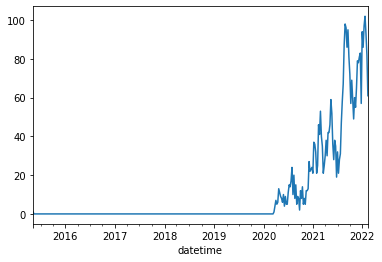

In [531]:
df.resample("W", on='datetime').size().plot()

In [501]:
# There's a campaign from 2015. What's up with that?
# Looks like this campaign *is* related to COVID, so I'm keeping it.
df[(df.datetime > '2015-05-01') & (df.datetime < '2015-05-30')]

,name,id,date,city,country,goal,progress,donations,currency,description,deactivated,url,datetime,city_list
314,Post COVID Recovery -Help- Life Saving Treatment,51830938,2015-05-07T03:45:20-05:00,"Torrance, CA",US,20000,8843,147,USD,Dear friends &amp; family-<br /> <br />Much gr...,False,NaN,2015-05-07,"[Torrance, CA]"


In [540]:
weekly_campaigns = df[df.datetime > "2015-06-01"].resample("W", on='datetime').size().sort_index().to_frame().reset_index().rename({0:'campaigns'},axis=1)

In [542]:
weekly_campaigns.to_csv("go-fund-me-weekly-campaigns.csv", index=False)

In [559]:
weekly_sum = df[(df.datetime > "2015-06-01") & (df.goal != 1)].resample("W", on='datetime').goal.sum().round().sort_index().to_frame().reset_index().rename({0:'campaigns'},axis=1)

In [560]:
weekly_mean = df[(df.datetime > "2015-06-01") & (df.goal != 1)].resample("W", on='datetime').goal.mean().round().sort_index().to_frame().reset_index().rename({0:'campaigns'},axis=1)

In [562]:
weekly_stats = weekly_campaigns.merge(weekly_sum, how="left", left_on="datetime", right_on="datetime")

In [565]:
weekly_stats = weekly_stats.merge(weekly_mean, how="left", left_on="datetime", right_on="datetime")

In [569]:
weekly_stats = weekly_stats.rename({'goal_x': 'sum', 'goal_y': 'mean'}, axis=1)

In [570]:
weekly_stats.to_csv("go-fund-me-weekly-stats.csv", index=False)

In [572]:
monthly_sum = df[(df.datetime > "2015-06-01") & (df.goal != 1)].resample("M", on='datetime').goal.sum().round().sort_index().to_frame().reset_index().rename({0:'campaigns'},axis=1)

In [575]:
monthly_sum.to_csv("go-fund-me-monthly-sum.csv", index=False)

['  Hello, my name is Maria. My aunt is hospitalized in Bolivia with COVID and she has pneumonia. Her medical bills are currently at USD$4,900 and will likely be higher. The family is grateful for any donation amount to help pay the medical bills.  Thank you and stay safe.   img class="m-text-editor-image" alt=""   src="https://d2g8igdw686xgo.cloudfront.net/62282591_1640845180505078_r."   /      ',
 '  Hi! My name is Shayna. I am Miranda\'s younger sister.          As many of you know, Miranda was hospitalized with Covid on November 20th.          Her symptoms started out as a regular cold virus with some sore throat and body aches. She was starting to feel slightly better, when she took a turn and decided to get tested. After testing positive 12 days ago, she took a turn for the worse.          She had stopped responding to my text and calls and even forgot it was my daughter\'s birthday (Which it you know how much Miranda loves Evie, she is ALWAYS the first to message "Happy Birthday

### Create separate city and state columns

In [197]:
df['city_list'] = df.city.str.split(",")

In [198]:
df['city_list'] = df.city_list.fillna("None")

In [199]:
# Narrowing down to US because that's where I want to focus my analysis,
# Also the not all have a "state"

us = df.query('country == "US"')

In [200]:
# Filtering out other countries:
us = us[~us.name.str.contains("India", case=False)]

In [201]:
us = us[~us.name.str.contains("Philippines", case=False)]

In [202]:
def state(city_list):
    try:
        return city_list[1]
    except:
        return None
    
def city(city_list):
    try:
        return city_list[0]
    except:
        return None

In [203]:
us['state'] = us.city_list.apply(state)
us['city_1'] = us.city_list.apply(city)

### Where are these gofundmes from?

It's important to note that the location information extracted from the meta data is the location of the creator. The creator might be in a completely different state than the recipient.

In [204]:
us.state.value_counts().head(10)

 TX    418
 CA    339
 FL    233
 OH    144
 NY    143
 GA    122
 IL    121
 AZ    121
 PA    111
 NC    109
Name: state, dtype: int64

### How much money is represented here?

Over $54 million

In [36]:
us.goal.sum()

54849919

In [628]:
us[us.goal !=1].describe()

,id,goal,progress,donations,progress_pct
count,3.514000e+03,3514.000000,3514.000000,3514.000000,3514.000000
mean,5.833324e+07,15608.967558,4523.416904,46.793113,41.455322
std,4.100014e+06,29082.411207,9222.215672,88.190605,60.188028
min,3.472936e+07,69.000000,0.000000,0.000000,0.000000
25%,5.557765e+07,4000.000000,295.000000,5.000000,4.000000
50%,5.962766e+07,8000.000000,1756.500000,19.000000,24.000000
75%,6.156860e+07,15000.000000,5191.750000,53.000000,61.000000
max,6.327115e+07,500000.000000,225020.000000,1772.000000,1276.000000


In [629]:
us[us.goal !=1].describe()

8000.0

In [702]:
us.progress.sum()

15923633

## Let's look at ventilator related posts

They make up for almost half of dollar goals.

In [584]:
from plotnine import *

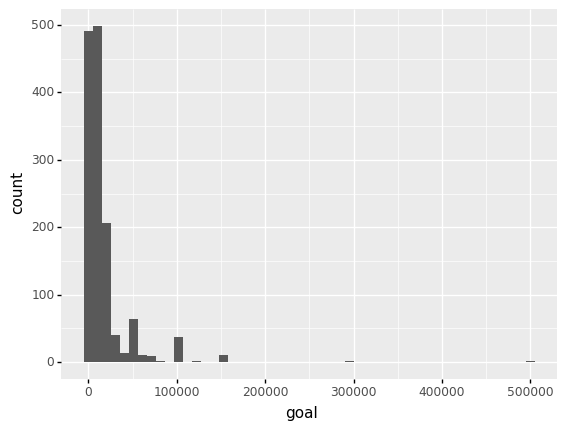

<ggplot: (361742011)>

In [587]:
(
ggplot(us[us.description.str.contains("ventilator")],
      aes("goal"))
    + geom_histogram(bins=50)
    + 
)

<AxesSubplot:>

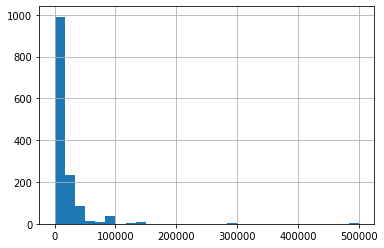

In [581]:
us[us.description.str.contains("ventilator")].goal.hist(bins=30)

In [588]:
us[us.description.str.contains("ventilator")].describe()

,id,goal,progress,donations,progress_pct
count,1.395000e+03,1395.000000,1395.000000,1395.000000,1.395000e+03
mean,5.827798e+07,18987.136201,6505.220072,66.618638,1.540027e+03
std,4.296880e+06,34114.909035,12039.325625,114.350104,4.758834e+04
min,3.472936e+07,1.000000,0.000000,0.000000,0.000000e+00
25%,5.513057e+07,5000.000000,1000.000000,12.500000,1.100000e+01
50%,5.982312e+07,10000.000000,3010.000000,35.000000,3.400000e+01
75%,6.155425e+07,20000.000000,7454.500000,79.000000,7.300000e+01
max,6.326638e+07,500000.000000,225020.000000,1772.000000,1.764600e+06


<AxesSubplot:>

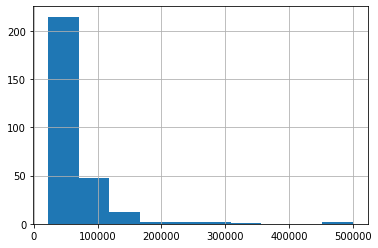

In [591]:
us[(us.description.str.contains("ventilator")) & (us.goal > 20000)].goal.hist()

In [583]:
us[us.goal > 300000].description.to_list()

['   My little brother Dustin was diagnosed with Type 1 Diabetes at the age of 12. He has taken good care of himself and has not been admitted to the hospital since that diagnosis.            Dustin is now 43 years old. He spent his birthday, December 27th, on the couch fighting Covid. He continued to say he did not want to go to the hospital in fear of being placed on a ventilator and never waking up again. However, on January 1st his oxygen levels dipped into the 70’s and his girlfriend forced him to let her take him to the hospital. When they arrived his oxygen was at 58. He is now in the ICU putting up the fight of his life.            My brother has no health insurance. I know he’s worrying about that while he’s in the hospital, alone, fighting to get better. I’d like to take that weight off his shoulders because he’s carrying enough right now.            I am pleading to everyone out there who has a brother, a Dad, or any family member that is larger than life to please help my b

In [37]:
# What's the sum of the goals of all campaigns that mention ventilator
us[us.description.str.contains("ventilator")].goal.sum()

26487055

In [230]:
# What states have the most ventilator-related campaigns?
us[us.description.str.contains("ventilator")].state.value_counts().head(10)

 TX    154
 CA    114
 FL     86
 OH     64
 MI     55
 NY     51
 PA     50
 NC     46
 CO     45
 IL     42
Name: state, dtype: int64

In [231]:
# Cities?
us[us.description.str.contains("ventilator")].city.value_counts().head(10)

Fort Worth, TX     11
San Antonio, TX    10
Houston, TX         9
Los Angeles, CA     9
New York, NY        8
El Paso, TX         7
Phoenix, AZ         7
Miami, FL           6
Orlando, FL         6
Austin, TX          5
Name: city, dtype: int64

### Looks like the average campaign is $19,000 and median is 10K

In [626]:
# Filtering out one campaign that had a goal of $1 because it doesn't give me 
# an idea of how much bills are costing

us[(us.description.str.contains("ventilator")) & (us.goal != 1)].describe()

,id,goal,progress,donations,progress_pct
count,1.391000e+03,1391.000000,1391.000000,1391.000000,1391.000000
mean,5.828057e+07,19041.733285,6509.008627,66.608914,52.650611
std,4.289804e+06,34148.731229,12050.209710,114.398324,76.229964
min,3.472936e+07,105.000000,0.000000,0.000000,0.000000
25%,5.513057e+07,5000.000000,1000.000000,12.500000,11.000000
50%,5.982312e+07,10000.000000,3010.000000,35.000000,34.000000
75%,6.154305e+07,20000.000000,7454.500000,79.000000,73.000000
max,6.326638e+07,500000.000000,225020.000000,1772.000000,1276.000000


In [630]:
# Filtering out one campaign that had a goal of $1 because it doesn't give me 
# an idea of how much bills are costing

us[(us.description.str.contains("ventilator")) & (us.goal != 1)].goal.sum()

26487051

In [701]:
us[(us.description.str.contains("ventilator")) & (us.goal != 1)].progress.sum()

9054031

In [704]:
us.describe()

,id,goal,progress,donations,progress_pct
count,3.521000e+03,3521.000000,3521.000000,3521.000000,3.521000e+03
mean,5.833220e+07,15577.937802,4522.474581,46.808577,8.464283e+02
std,4.102561e+06,29061.799074,9216.623847,88.169847,3.132374e+04
min,3.472936e+07,1.000000,0.000000,0.000000,0.000000e+00
25%,5.557720e+07,4000.000000,295.000000,5.000000,4.000000e+00
50%,5.962781e+07,8000.000000,1758.000000,19.000000,2.400000e+01
75%,6.156929e+07,15000.000000,5185.000000,53.000000,6.200000e+01
max,6.327115e+07,500000.000000,225020.000000,1772.000000,1.764600e+06


### Average progress is 6,500 and median is 3,000

In [41]:
us[(us.description.str.contains("ventilator")) & (us.goal != 1)].progress.describe()

count      1391.000000
mean       6509.008627
std       12050.209710
min           0.000000
25%        1000.000000
50%        3010.000000
75%        7454.500000
max      225020.000000
Name: progress, dtype: float64

In [42]:
us[(us.description.str.contains("ventilator")) & (us.goal != 1)].progress.median()

3010.0

In [254]:
us[(us.description.str.contains("ventilator")) & (us.goal != 1)].progress.mode()

0    0
dtype: int64

In [257]:
us['progress_pct'] = ((us.progress / us.goal)*100).round()

In [264]:
# The 1 dollar goals are throwing the percentage off with crazy percents like 1,764,600% lollll
us.query("goal != 1").progress_pct.median()

24.0

In [265]:
us.query("goal != 1").progress_pct.mean()

41.45532157085942

In [263]:
#56473763
us.sort_values('progress_pct', ascending=False)

,name,id,date,city,country,goal,progress,donations,currency,description,deactivated,url,datetime,city_list,state,city_1,progress_pct
3569,Herb (Boo) Billups,47658334,2020-04-25T15:18:45-05:00,"Bridgeport, CT",US,1,17646,236,USD,Herb (Boo) Billups Jr. has been at St. Vincent...,False,/f/herb-boo-billups?qid=efc0718ebaf56c6cd13c4a...,2020-04-25,"[Bridgeport, CT]",CT,Bridgeport,1764600.0
2835,Supporting the Smith’s,61513015,2021-11-26T19:30:55-06:00,"Gainesville, GA",US,1,4615,35,USD,"font color=""#333333"" Chris and Erin Smith are...",False,/f/q7zq8-charles039-angels?qid=6f0662a5aad16a7...,2021-11-26,"[Gainesville, GA]",GA,Gainesville,461500.0
934,Senior dog needs help after COVID death,53832192,2021-01-09T15:29:14-06:00,"Kenmore, WA",US,1,2880,65,USD,Hi all. My mom died of COVID and I have inheri...,False,/f/senior-dog-needs-help-after-covid-death?qid...,2021-01-09,"[Kenmore, WA]",WA,Kenmore,288000.0
3087,Help Frank survive Covid,62882839,2022-01-25T21:09:10-06:00,"Fond du Lac, WI",US,1,1950,25,USD,"Hello again, My name is Patrick Bib...",False,/f/help-frank-survive-covid?qid=379c74f3ab102f...,2022-01-25,"[Fond du Lac, WI]",WI,Fond du Lac,195000.0
3300,Help with funeral expenses for Matt Dallas,62759071,2022-01-20T19:08:05-06:00,"Kennewick, WA",US,1,870,13,USD,We are saddened to announce that in the early ...,False,/f/help-with-funeral-expenses-for-matt-dallas?...,2022-01-20,"[Kennewick, WA]",WA,Kennewick,87000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,Help Small Business Owners recover from COVID,56473763,2021-04-29T09:02:24-05:00,"Boynton Beach, FL",US,250000,0,0,USD,I arrange commercial lending for small busin...,False,/f/relief-for-small-business-owners-from-covid...,2021-04-29,"[Boynton Beach, FL]",FL,Boynton Beach,0.0
2072,Help Praveen and his family recover from COVID-19,56382060,2021-04-26T02:20:48-05:00,"Fremont, CA",US,10000,0,0,USD,"My friend Praveen, his wife and his aged fathe...",False,/f/help-praveen-and-his-family-recover-from-co...,2021-04-26,"[Fremont, CA]",CA,Fremont,0.0
2073,"Please help Joe recover from Covid-19, and the...",56312670,2021-04-23T11:34:40-05:00,"Addison, IL",US,22400,0,0,USD,"Just over a month ago, my father, Joe J. Sag...",False,/f/please-help-joe-recover-from-Covid?qid=442e...,2021-04-23,"[Addison, IL]",IL,Addison,0.0
2074,Help Christine Recover from Covid,56242784,2021-04-20T19:25:48-05:00,"Dover, DE",US,500,0,0,USD,"I am hoping to raise money for my relative, Ch...",False,/f/help-christine-recover-from-covid?qid=442e3...,2021-04-20,"[Dover, DE]",DE,Dover,0.0


### Text Analysis: Hospital stays

In [295]:
hospitalized = us[us.description.str.contains('hospitalized')].description.to_list()

In [314]:
for story in hospitalized:
    query = re.findall(r".{25}\d\d?\d? days in t?h?e?.*icu.{25}", story, re.IGNORECASE)
    if len(query) > 0:
        print(query)

["s finally released after 17 days in the hospital on January 27, 2022.         Michelle now faces a long recovery: doctors estimate that it will take her over a year to gain back functionality like normal movement and cognition, though there is much unknown about long term recovery from COVID-19. The the impact on her health will most likely be permanent, with many elements taking years to approach her pre-virus levels of functionality. Her family also faces mounting hospital bills and the burden of expenses necessary for her health that simply did not exist in their budget before this tragedy.         Her friends and family are asking you to donate what you can to help us reach our goal to aide Michelle in her recovery. She is an incredible educator who has devoted her life towards giving her students the best opportunity to thrive in a challenging world. She has seen her family through medical events, financial challenges, and heartbreak; from her mother's stroke recovery for over t

In [43]:
us_text = us.description.to_list()

In [280]:
us.description.str.contains("in the hospital", case=False).value_counts()

False    2204
True     1317
Name: description, dtype: int64

In [281]:
us[us.description.str.contains("in the hospital", case=False)].goal.mean()

17672.26727410782

In [284]:
us.description.str.contains("bills", case=False).value_counts()

False    1772
True     1749
Name: description, dtype: int64

In [286]:
us[us.description.str.contains("bills", case=False)].goal.mean()

15738.489422527158

In [287]:
us.goal.mean()

15577.937801760863

In [289]:
us[us.description.str.contains("icu", case=False)].goal.mean()

18915.576283441795

In [636]:
# I wanted to make sure I wasn't capturing duplicate hospital stays per description
# so I created a dictionary for each story to capture multiple mentions of stays

hospital_stays = []
icu_stays = []
ventilator_stays = []
for text in us_text:
    hospital_story = {}
    icu_story = {}
    ventilator_story = {}
    
    hospital_days = re.findall(r"(\d\d?\d?) days in the hospital", text, re.IGNORECASE)
    hospital_days_2 = re.findall(r"hospital for (\d\d?\d?) days", text, re.IGNORECASE)
    hospital_weeks = re.findall(r"(\d\d?) weeks? in the hospital", text, re.IGNORECASE)
    hospital_weeks_2 = re.findall(r"hospital for (\d\d?) weeks?", text, re.IGNORECASE)
    hospital_months = re.findall(r"(\d\d?) months? in the hospital", text, re.IGNORECASE)
    hospital_months_2 = re.findall(r"hospital for (\d\d?) months?", text, re.IGNORECASE)
       
    
    
    icu_days = re.findall(r"(\d\d?\d?) days in t?h?e?\s?c?o?v?i?d?\s?icu", text, re.IGNORECASE)
    icu_weeks = re.findall(r"(\d\d?) weeks? in t?h?e?\s?c?o?v?i?d?\s?icu", text, re.IGNORECASE)
    icu_months = re.findall(r"(\d\d?) months? in t?h?e?\s?c?o?v?i?d?\s?icu", text, re.IGNORECASE)
    icu_days_2 = re.findall(r"icu for (\d\d?\d?) days", text, re.IGNORECASE)
    icu_weeks_2 = re.findall(r"icu for (\d\d?) weeks?", text, re.IGNORECASE)
    icu_months_2 = re.findall(r"icu for (\d\d?) months?", text, re.IGNORECASE)
    
    
    ventilator_days= re.findall(r"ventilator for (\d\d?\d?) days", text, re.IGNORECASE)
    ventilator_weeks= re.findall(r"ventilator for (\d\d?) weeks?", text, re.IGNORECASE)
    ventilator_days_2 = re.findall(r"(\d\d?\d?) days? on a?t?h?e? ventilator", text, re.IGNORECASE)
    ventilator_weeks_2 = re.findall(r"(\d\d?) weeks? on a?t?h?e? ventilator", text, re.IGNORECASE)
    ventilator_months_2 = re.findall(r"(\d\d?\d?) months? on a?t?h?e? ventilator", text, re.IGNORECASE)
    ventilator_months = re.findall(r"ventilator for (\d\d?) months?", text, re.IGNORECASE)
    

    if len(hospital_days) > 0:
        hospital_story['hospital_days'] = hospital_days[0]
    if len(hospital_days_2) > 0:
        hospital_story['hospital_days_2'] = hospital_days_2[0]
    if len(hospital_weeks) > 0:
        hospital_story['hospital_weeks'] = hospital_weeks[0]
    if len(hospital_weeks_2) > 0:
        hospital_story['hospital_weeks_2'] = hospital_weeks_2[0]
    if len(hospital_months) > 0:
        hospital_story['hospital_months'] = hospital_months[0]
    if len(hospital_months_2) > 0:
        hospital_story['hospital_months_2'] = hospital_months_2[0]
    
        
        
    if len(icu_days) > 0:
        icu_story['icu_days'] = icu_days[0]
    if len(icu_weeks) > 0:
        icu_story['icu_weeks'] = icu_weeks[0]
    if len(icu_months) > 0:
        icu_story['icu_months'] = icu_months[0]
    if len(icu_days_2) > 0:
        icu_story['icu_days_2'] = icu_days_2[0]
    if len(icu_weeks_2) > 0:
        icu_story['icu_weeks_2'] = icu_weeks_2[0]
    if len(icu_months_2) > 0:
        icu_story['icu_months_2'] = icu_months_2[0]
        
        
    if len(ventilator_days) > 0:
        ventilator_story['ventilator_days'] = ventilator_days[0]
    if len(ventilator_weeks) > 0:
        ventilator_story['ventilator_weeks'] = ventilator_weeks[0]
    if len(ventilator_days_2) > 0:
        ventilator_story['ventilator_days_2'] = ventilator_days_2[0]
    if len(ventilator_weeks_2) > 0:
        ventilator_story['ventilator_weeks_2'] = ventilator_weeks_2[0]
    if len(ventilator_months) > 0:
        ventilator_story['ventilator_months'] = ventilator_months[0]
    if len(ventilator_months_2) > 0:
        ventilator_story['ventilator_months_2'] = ventilator_months_2[0]
    

    if len(hospital_story) > 0:
        hospital_stays.append(hospital_story)
    if len(icu_story) > 0:
        icu_stays.append(icu_story)
    if len(ventilator_story) > 0:
        ventilator_stays.append(ventilator_story)


In [637]:
len(hospital_stays)

159

In [638]:
hospital_df = pd.DataFrame(hospital_stays)

In [639]:
hospital_df

,hospital_days_2,hospital_days,hospital_months_2,hospital_weeks_2,hospital_weeks,hospital_months
0,3,NaN,NaN,NaN,NaN,NaN
1,NaN,23,NaN,NaN,NaN,NaN
2,NaN,NaN,6,NaN,NaN,NaN
3,NaN,NaN,NaN,3,NaN,NaN
4,NaN,NaN,NaN,3,NaN,NaN
5,NaN,17,NaN,NaN,NaN,NaN
6,NaN,10,NaN,NaN,NaN,NaN
7,NaN,78,NaN,NaN,NaN,NaN
8,NaN,135,NaN,NaN,NaN,NaN
9,5,NaN,NaN,NaN,NaN,NaN


In [640]:
icu_df = pd.DataFrame(icu_stays)

In [641]:
icu_df

,icu_days_2,icu_months,icu_weeks,icu_days,icu_weeks_2,icu_months_2
0,10,NaN,NaN,NaN,NaN,NaN
1,NaN,6,NaN,NaN,NaN,NaN
2,NaN,NaN,2,NaN,NaN,NaN
3,NaN,NaN,NaN,6,NaN,NaN
4,10,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,2,NaN
6,NaN,NaN,2,NaN,NaN,NaN
7,40,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,33,NaN,NaN
9,NaN,NaN,2,NaN,NaN,NaN


In [674]:
icu_df = icu_df.fillna(0)
icu_df = icu_df[['icu_days','icu_months_2','icu_days_2','icu_weeks','icu_months','icu_weeks_2']].astype("int")
icu_df['months'] = icu_df.icu_months_2 + icu_df.icu_months
icu_df['weeks'] = icu_df.icu_weeks_2 + icu_df.icu_weeks
icu_df['days'] = icu_df.icu_days_2 + icu_df.icu_days
icu_df['months'] = icu_df.months.apply(month_days)
icu_df['weeks'] = icu_df.weeks.apply(week_days)
icu_df['all_stays'] = icu_df.months + icu_df.weeks + icu_df.days

In [675]:
icu_df

,icu_days,icu_months_2,icu_days_2,icu_weeks,icu_months,icu_weeks_2,months,weeks,days,all_stays
0,0,0,10,0,0,0,0,0,10,10
1,0,0,0,0,6,0,180,0,0,180
2,0,0,0,2,0,0,0,14,0,14
3,6,0,0,0,0,0,0,0,6,6
4,0,0,10,0,0,0,0,0,10,10
5,0,0,0,0,0,2,0,14,0,14
6,0,0,0,2,0,0,0,14,0,14
7,0,0,40,0,0,0,0,0,40,40
8,33,0,0,0,0,0,0,0,33,33
9,0,0,0,2,0,0,0,14,0,14


In [677]:
icu_df.all_stays.describe()

count     50.000000
mean      27.300000
std       29.162633
min        3.000000
25%       14.000000
50%       17.500000
75%       34.750000
max      180.000000
Name: all_stays, dtype: float64

In [656]:
ventilator_df = pd.DataFrame(ventilator_stays)

In [657]:
ventilator_df

,ventilator_days,ventilator_months_2,ventilator_days_2,ventilator_weeks,ventilator_months,ventilator_weeks_2
0,21,NaN,NaN,NaN,NaN,NaN
1,NaN,4,NaN,NaN,NaN,NaN
2,9,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,60,NaN,NaN,NaN
4,NaN,NaN,20,NaN,NaN,NaN
5,NaN,NaN,27,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN
7,NaN,2,NaN,NaN,NaN,NaN
8,30,NaN,NaN,NaN,NaN,NaN
9,60,NaN,NaN,NaN,NaN,NaN


In [670]:
ventilator_df = ventilator_df.fillna(0)
ventilator_df = ventilator_df[['ventilator_days','ventilator_months_2','ventilator_days_2','ventilator_weeks','ventilator_months','ventilator_weeks_2']].astype("int")
ventilator_df['months'] = ventilator_df.ventilator_months_2 + ventilator_df.ventilator_months
ventilator_df['weeks'] = ventilator_df.ventilator_weeks_2 + ventilator_df.ventilator_weeks
ventilator_df['days'] = ventilator_df.ventilator_days_2 + ventilator_df.ventilator_days
ventilator_df['months'] = ventilator_df.months.apply(month_days)
ventilator_df['weeks'] = ventilator_df.weeks.apply(week_days)
ventilator_df['all_stays'] = ventilator_df.months + ventilator_df.weeks + ventilator_df.days

In [672]:
ventilator_df.all_stays.describe()

count     94.000000
mean      26.425532
std       25.460275
min        3.000000
25%       14.000000
50%       18.000000
75%       28.000000
max      165.000000
Name: all_stays, dtype: float64

In [414]:
def month_days(months):
    return months * 30

def week_days(weeks):
    return weeks * 7

In [707]:
hospital_df = hospital_df.fillna(0)

In [708]:
hospital_df = hospital_df[['hospital_days_2','hospital_days','hospital_months_2','hospital_weeks_2','hospital_weeks','hospital_months']].astype("int")

In [709]:
hospital_df['months'] = hospital_df.hospital_months_2 + hospital_df.hospital_months

In [710]:
hospital_df['days'] = hospital_df.hospital_days_2 + hospital_df.hospital_days

In [711]:
hospital_df['weeks'] = hospital_df.hospital_weeks_2 + hospital_df.hospital_weeks

In [712]:
hospital_df['months'] = hospital_df.months.apply(month_days)

In [713]:
hospital_df['weeks'] = hospital_df.weeks.apply(week_days)

In [714]:
hospital_df['all_stays'] = hospital_df.months + hospital_df.weeks + hospital_df.days

<AxesSubplot:>

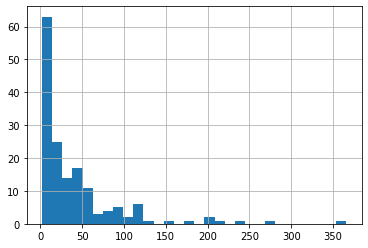

In [457]:
hospital_df.all_stays.hist(bins=30)

In [458]:
hospital_df.all_stays.describe()

count    159.000000
mean      42.679245
std       54.421622
min        2.000000
25%       11.000000
50%       21.000000
75%       53.000000
max      366.000000
Name: all_stays, dtype: float64

In [459]:
hospital_df.all_stays.median()

21.0

In [715]:
hospital_df['all_days'] = hospital_df.months + hospital_df.days + hospital_df.weeks

In [593]:
hospital_df.all_days.describe()

count    159.000000
mean      42.679245
std       54.421622
min        2.000000
25%       11.000000
50%       21.000000
75%       53.000000
max      366.000000
Name: all_days, dtype: float64

In [721]:
def categorize(days):
    if days < 11:
        return "0 - 10"
    if days < 21:
        return "11 - 20"
    if days < 31:
        return "21 - 40"
    if days < 61:
        return "41 - 60"
    if days < 81:
        return "61 - 80"
    if days < 101:
        return "81 - 100"
    if days < 151:
        return "101 - 150"
    if days < 201:
        return "161 - 200"
    if days < 251:
        return "201 - 250"
    if days < 301:
        return "250 - 300"
    if days > 300:
        return "300+"

In [722]:
hospital_df['categories'] = hospital_df.all_days.apply(categorize)

In [726]:
hospital_df['categories'].value_counts().to_frame().reset_index()

,index,categories
0,0 - 10,38
1,11 - 20,35
2,41 - 60,34
3,21 - 40,23
4,101 - 150,10
5,81 - 100,7
6,61 - 80,5
7,201 - 250,3
8,161 - 200,2
9,300+,1


In [718]:
hospital_df.all_days.to_frame().to_csv("go-fund-me-hospital-stays.csv",index=False)

In [632]:
ventilator_df

,ventilator_days,ventilator_days_2,ventilator_weeks,ventilator_weeks_2
0,21,NaN,NaN,NaN
1,9,NaN,NaN,NaN
2,NaN,60,NaN,NaN
3,NaN,20,NaN,NaN
4,NaN,27,NaN,NaN
5,6,NaN,NaN,NaN
6,30,NaN,NaN,NaN
7,60,NaN,NaN,NaN
8,NaN,NaN,4,NaN
9,10,NaN,NaN,NaN


In [473]:
us[us.description.str.contains("5 months in the hospital")]

,name,id,date,city,country,goal,progress,donations,currency,description,deactivated,url,datetime,city_list,state,city_1,progress_pct
2773,Help Hudson kick CF Expenses & Family Med Bills,62494673,2022-01-08T20:25:53-06:00,"Appleton, WI",US,30000,11875,109,USD,"Hi, my name is Katie. We are raising funds ...",False,/f/q7zq8-charles039-angels?qid=6f0662a5aad16a7...,2022-01-08,"[Appleton, WI]",WI,Appleton,40.0


In [464]:
us[us.description.str.contains("hospital for 366")]

,name,id,date,city,country,goal,progress,donations,currency,description,deactivated,url,datetime,city_list,state,city_1,progress_pct
2842,Help me get portable oxygen!,62141755,2021-12-22T15:24:36-06:00,"Laredo, TX",US,4000,2080,37,USD,"Hi, my name is Sam, and you might’ve seen my...",False,/f/q7zq8-charles039-angels?qid=6f0662a5aad16a7...,2021-12-22,"[Laredo, TX]",TX,Laredo,52.0


In [463]:
us[us.description.str.contains("hospital for 366")].description.to_list()

['  Hi, my name is Sam, and you might’ve seen my story on Facebook! I got COVID, was in the hospital for 366 days, and went through so much medical trauma. Now that I’m home, I’m currently dependent on oxygen. We have 2 tanks and a regular converter. But when it’s time for me to go out in public or to my doctors’ appointments, I’ll have to haul a giant tank with me. I’ve never done anything like this before, but I didn’t know a portable oxygen machine would be so expensive. The smallest donations would help me get this machine and reduce the burden of the other medical bills my family and I have to work through.         Thank you so so so much for even taking the time to read this!  ']

In [465]:
us[us.description.str.contains("205 days in the hospital")]

,name,id,date,city,country,goal,progress,donations,currency,description,deactivated,url,datetime,city_list,state,city_1,progress_pct
1286,George's Fearless Covid Battle,53895062,2021-01-12T14:51:17-06:00,"Azusa, CA",US,10000,3919,62,USD,"img src=""https://d2g8igdw686xgo.cloudfront.ne...",False,/f/georges-fearless-covid-battle?qid=a7fbba8a8...,2021-01-12,"[Azusa, CA]",CA,Azusa,39.0


In [470]:
us[us.description.str.contains("hospital for 109")].url.value_counts()

/f/covid-recovery-after-109-days-in-hospital?qid=fb288803e2711190f3835464beacedf8    1
Name: url, dtype: int64

In [ ]:
us[us.description.str.contains("135 days in the hospital")]

In [ ]:
us[us.description.str.contains("205 days in the hospital")]

In [137]:
## How many mention medical bills?
us[(us.description.str.contains("medical bill", case=False)) | (us.name.str.contains("medical bill", case = False)) | (us.description.str.contains("hospital bill", case = False))]

,name,id,date,city,country,goal,progress,donations,currency,description,deactivated,url,datetime,city_list,state,city_1
0,Help Alex Wilson with Covid Medical Bills,62898511,2022-01-26T21:31:12-06:00,"Sherrard, IL",US,18000,18500,138,USD,\n<div>He’s always there for anyone who needs ...,False,NaN,2022-01-26,"[Sherrard, IL]",IL,Sherrard
1,Help Spencer With Covid Medical Bills,62733635,2022-01-19T11:54:28-06:00,"Grantsville, UT",US,10000,2188,37,USD,"\n<p>If you know Spencer, you love him. There ...",False,NaN,2022-01-19,"[Grantsville, UT]",UT,Grantsville
2,Funeral and Covid medical bills,63058075,2022-02-02T17:04:58-06:00,"Maricopa, AZ",US,50000,5645,43,USD,\n<div>I honestly never imagined that my famil...,False,NaN,2022-02-02,"[Maricopa, AZ]",AZ,Maricopa
3,Help My Dad Pay for My Mom's COVID Medical Bills,63006803,2022-01-31T19:30:28-06:00,"Rochester, MN",US,5000,1025,14,USD,\n<div>Hi. My name is Amy. I lost my mom to Co...,False,NaN,2022-01-31,"[Rochester, MN]",MN,Rochester
4,Help the Kuhne family with Shaun’s Final expenses,62136867,2021-12-22T11:28:55-06:00,"Hermitage, PA",US,2000,2195,30,USD,\n<div>Hi my name is Melana and I am fund rais...,False,NaN,2021-12-22,"[Hermitage, PA]",PA,Hermitage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,Help Dad Recover,60768781,2021-10-24T11:29:17-05:00,"Mountain Top, PA",US,10000,655,11,USD,\n<div>Our father Joseph Benjamin is the rock ...,False,/f/9ktezr-help-dad-recover?qid=aeb400d2c7cee28...,2021-10-24,"[Mountain Top, PA]",PA,Mountain Top
3704,Medical Bills & Healing,63110837,2022-02-04T20:55:38-06:00,"Houston, TX",US,15000,1875,18,USD,"\n<div><img src=""https://d2g8igdw686xgo.cloudf...",False,/f/LindaleNichols-medical-bills-healing?qid=b3...,2022-02-04,"[Houston, TX]",TX,Houston
3706,Help Dale Collins Family with Medical Bills,61967083,2021-12-15T14:41:41-06:00,"Barberton, OH",US,15000,12892,154,USD,\n<div><br />\n</div>\n<div>The Collins family...,False,/f/help-dale-collins-family-with-medical-bills...,2021-12-15,"[Barberton, OH]",OH,Barberton
3708,Help Chad Wohlgamuth’s Family,62958847,2022-01-29T09:04:21-06:00,"Lima, OH",US,25000,2602,25,USD,\n<div>Chad Wohlgamuth passed away on January ...,False,/f/help-chad-wohlgamuths-family?qid=b3e4e8cba0...,2022-01-29,"[Lima, OH]",OH,Lima


In [595]:
medical_bills = us[(us.description.str.contains("medical bill", case=False))
   | (us.name.str.contains("medical bill", case = False))
   | (us.description.str.contains("hospital bill", case = False))
   | (us.description.str.contains("medical cost", case=False)) 
   | (us.name.str.contains("hospital bill", case = False))
   | (us.name.str.contains("medical cost", case=False))]

In [596]:
medical_bills.goal.sum()

24947032

In [599]:
medical_bills[medical_bills.goal != 1].describe()

,id,goal,progress,donations,progress_pct
count,1.297000e+03,1297.000000,1297.000000,1297.000000,1297.000000
mean,5.879025e+07,19234.410948,5119.014649,50.936006,39.506554
std,3.983140e+06,33147.389624,9322.155108,93.596305,51.401817
min,3.480684e+07,200.000000,0.000000,0.000000,0.000000
25%,5.618237e+07,5000.000000,501.000000,7.000000,6.000000
50%,5.995171e+07,10000.000000,2125.000000,24.000000,23.000000
75%,6.199091e+07,20000.000000,6085.000000,61.000000,58.000000
max,6.327115e+07,500000.000000,109425.000000,1772.000000,525.000000


In [608]:
us[(us.description.str.contains("died")) | (us.description.str.contains("passed away")) | (us.description.str.contains("funeral"))].goal.describe()

count       449.000000
mean      19571.587973
std       32807.551868
min           1.000000
25%        5000.000000
50%       10000.000000
75%       20000.000000
max      350000.000000
Name: goal, dtype: float64

In [623]:
us[(us.goal !=1) & (us.description.str.contains("funeral"))].describe()

,id,goal,progress,donations,progress_pct
count,2.300000e+02,230.000000,230.000000,230.000000,230.00000
mean,5.720189e+07,19563.478261,7226.395652,74.839130,48.03913
std,4.666205e+06,28625.910349,12794.451236,112.394134,51.63834
min,4.695376e+07,500.000000,0.000000,0.000000,0.00000
25%,5.394223e+07,5500.000000,1598.750000,17.000000,15.50000
50%,5.895296e+07,10000.000000,3573.500000,42.500000,35.00000
75%,6.109121e+07,20000.000000,7997.500000,77.250000,68.00000
max,6.326250e+07,250000.000000,102742.000000,790.000000,525.00000


In [625]:
us[(us.goal !=1) & (us.description.str.contains("funeral"))].description.to_list()

["  I honestly never imagined that my family would be put in a position where we would need to be so vulnerable. Like a lot of people, Covid has impacted our family in a way that will change us forever .     \xa0     Two weeks ago, my dad was happy and healthy. Riding his bike around his neighborhood and sending me his workout badge for the day, telling me how many miles he had just completed.     \xa0     My dad managed to stay healthy during this pandemic. On Friday, Jan 14th, he started with a very mild headache. I took him immediately to our family doctor. We had a plan, which included keeping him out of the hospital. His symptoms ebbed and flowed over the next few days, but he was stable and ok. By Wednesday, he started having neurological symptoms that required an ER visit. He was treated and sent home. The following 3 days, he became progressively worse, and his O2 went down into the 70’s. We called the ambulance right away to get him to the local hospital. My daughter and I sta

In [153]:
hospital_visits.description.str.contains("ventilator", case=False).value_counts()

False    779
True     519
Name: description, dtype: int64

In [154]:
us.description.str.contains("ventilator", case=False).value_counts()

False    2102
True     1419
Name: description, dtype: int64

In [156]:
count = 0
for text in us_text:
    query = re.findall(r".{15}ventilator.{15}", text, re.IGNORECASE)
    if len(query) > 0:
        print(query)
        count=count+1
count

['currently on a ventilator in the ICU in ']
['O2 support the ventilator would give him']
['currently on a ventilator at Utah valley', 'will be on the ventilator, nor his recov', 'd &amp; on the ventilator but everything']
['d and put on a ventilator.  He has spent']
['him off of the ventilator, and we hope i']
[' coma and on a ventilator to allow her b']
['as placed on a ventilator yesterday morn']
['as placed on a ventilator &amp; put on a', ' is still on a ventilator as well as the']
['en placed on a ventilator and later indu']
[' been put on a Ventilator, Medically Ind']
[' off the trach-ventilator to get a bette', 'was put on the ventilator, a hail storm ']
["id. She's on a ventilator and  has been "]
['nd placed on a ventilator on December 2n', 'e remains on a ventilator in the ICU and']
[' comes off the ventilator. As expected, ']
['presently on a ventilator and receiving ']
['ly placed on a ventilator and feeding tu', ' placed on the ventilator, she was able ', 'le to have the 

['19. He is on a ventilator and can use yo', ' stable on the ventilator at the moment ']
['9 and was on a ventilator . My dad wante']
['he’s been on a ventilator for the last w']
['en placed on a ventilator. In February h']
['9. He was on a ventilator for almost a m']
['d was put on a ventilator on Sept 12. Sh']
[' has been on a ventilator.. today his lu']
['n the ICU on a ventilator she is our onl']
['d was put on a ventilator this week. Thi']
['r 3 weeks on a ventilator. They need all']
[' Kept her on a Ventilator and gave her m']
[' they put on a ventilator, a trachea and']
['d was put on a Ventilator yesterday Oct ']
['9 and put on a ventilator shortly after.']
[' has been on a ventilator for over two w', 'ut back on the ventilator about 4-5 hour']
['one bring on a ventilator for an extende', 'r son was on a ventilator, her landlord ']
['d was put on a ventilator today. There a']
['n the ICU on a ventilator with COVID  pn']
['as placed on a ventilator in the ICU sho']
['as placed o

1404

In [158]:
import numpy as np

In [205]:
us.description = us.description.str.replace("<div>", " ")

In [206]:
us.description = us.description.str.replace("\n", " ")

In [207]:
us.description = us.description.str.replace('media_type="3"', " ")

In [208]:
us.description = us.description.str.replace('width="100%"', " ")

In [232]:
us.description = us.description.str.replace('<p>', " ")

In [233]:
us.description = us.description.str.replace('</div>', " ")

In [236]:
us.description = us.description.str.replace('<br />', " ")

In [241]:
us.description = us.description.str.replace('</p>', " ")

In [242]:
us.description = us.description.str.replace('<span>', " ")

In [243]:
us.description = us.description.str.replace('</span>', " ")

In [246]:
us.description = us.description.str.replace('<', " ")

In [247]:
us.description = us.description.str.replace('>', " ")

In [248]:
us_description = us.description.to_list()

In [249]:
us.description

0         He’s always there for anyone who needs a han...
1         If you know Spencer, you love him. There is ...
2         I honestly never imagined that my family wou...
3         Hi. My name is Amy. I lost my mom to Covid i...
4         Hi my name is Melana and I am fund raising f...
                              ...                        
3715      Hello, my name is Courtney Jorgenson, I am t...
3716      My name is Staci Wolfford. I am trying to ra...
3717      Hi,     Thank you for reading this.  Yoko, a...
3718       Jason Minnear, a Moniteau High School Gradu...
3719      For those that don't know me my name is Cody...
Name: description, Length: 3521, dtype: object

In [250]:
textfile = open("go-fund-me-text.txt", "w")

for element in us_description:

    textfile.write(element + "\n")

textfile.close()

In [700]:
us.progress.sum()

15923633

In [ ]:
us.progress.sum()

In [ ]:
import nltk
nltk.download('genesis')
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

with open('go-fund-me-text.txt', 'r') as f:
    tokens = f.read().split()

# change this to read in your data
finder = BigramCollocationFinder.from_words(
    nltk.corpus.genesis.words(tokens))
# finder = us_description

finder.text_type.decode([encoding[ignore ,errors]]) 
# only bigrams that appear 3+ times
finder.apply_freq_filter(3)

# return the 10 n-grams with the highest PMI
finder.nbest(bigram_measures.pmi, 10)

In [329]:
!pip install -U numpy scipy scikit-learn

     |████████████████████████████████| 17.6 MB 31.0 MB/s eta 0:00:01
     |████████████████████████████████| 55.6 MB 164 kB/s  eta 0:00:01
     |████████████████████████████████| 8.0 MB 19.5 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
You should consider upgrading via the '/Users/shelbyjouppi/.pyenv/versions/3.9.7/bin/python3.9 -m pip install --upgrade pip' command.


In [332]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shelbyjouppi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [391]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(us['description'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [696]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(3,4))
# matrix of ngrams
ngrams = c_vec.fit_transform(us['description'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_trigram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [693]:
stoplist = stopwords.words('english') + ['img', 'src', 'https', 'line', 'height', 'style',
                                         'editor', 'image', 'span','text','d2g8igdw686xgo', 'cloudfront',
                                         'net', 'covid','19','medical bills', '51', 'class', 's1', 'p1',
                                        'letter', 'spacing', '_blank','rel','jpeg','alt','medical', 'bills',
                                         '0085px', 'href','www','facebook','com','font','333333','p2','min','youtube',
                                        'video', 'player','margin','20px','hi','strong','em','tested','positive',
                                        'rgb','255','sans','serif','en','la','de','noreferrer','noopener','nofollow']

In [697]:
df_trigram.head(25)
df_trigram

,frequency,bigram/trigram
0,1348,src https d2g8igdw686xgo cloudfront
1,1348,src https d2g8igdw686xgo
2,1348,https d2g8igdw686xgo cloudfront net
3,1348,https d2g8igdw686xgo cloudfront
4,1348,d2g8igdw686xgo cloudfront net
5,982,img src https
6,950,img src https d2g8igdw686xgo
7,402,tested positive covid
8,362,style line height
9,331,jpeg img src https


In [ ]:
# Dropping HTML 
df_ngram = df_ngram.drop(index=[1,2,3,4,5,6,7,9,10,11,16,17,19])

In [395]:
df_ngram = df_ngram.drop(index=[26,27,28,30,31,32,39,40,41,43,44,45,46,47,48,49,50,51]).head(50)

In [396]:
clean_ngram = df_ngram

In [689]:
# dropping things I searched for:
searches = ['covid 19', 'medical bills','covid pneumonia', 'tested positive', 'positive covid', 
            'diagnosed covid', 'tested positive covid', 'medical expenses', 'due covid', 'contracted covid','strong strong', 'ask help', 'friends family', 'needs help','year old','style font', 'href https www', 'battling covid']
clean_ngram[~clean_ngram['bigram/trigram'].isin(searches)]

,frequency,bigram/trigram
15,477,greatly appreciated
21,396,please help
23,372,need help
24,370,god bless
29,334,thank much
33,313,long road
34,312,get back
36,307,admitted hospital
37,305,put ventilator
38,300,asking help


In [691]:
clean_ngram[~clean_ngram['bigram/trigram'].isin(searches)].head(25).to_csv("go-fund-me-bigram-trigram.csv", index=False)

In [ ]:
duplicates = ['friends family']
odd phrases = ['year old']

In [362]:
from nltk.probability import FreqDist
def get_collocations(words):
	# returns n-grams up to trigrams that appear at least 3 times, with pruning of grams that are redundant
	minimum_frequency = 3
	ngrams = {"_".join(ngram): frequency/len(words) for ngram, frequency in FreqDist(everygrams(words, max_len=3)).items() if frequency > minimum_frequency}
	collocations = dict(ngrams)
	for ngram, likelihood in dict(ngrams).iteritems():
		grams = ngram.split("_")
		if len(grams) != 1:
			gram_likelihoods = [ngrams[gram] for gram in grams]
			if likelihood < 0.5 * np.prod(gram_likelihoods)**(1 / len(grams)):
				collocations.pop(ngram, None)
			else:
				for gram in grams:
					collocations.pop(gram, None)
	return sorted(collocations.items(), key=itemgetter(1), reverse=True) 

In [384]:
stoplist = stopwords.words('english') + ['img', 'src', 'https', 'line', 'height', 'style',
                                         'editor', 'image', 'span','text','d2g8igdw686xgo', 'cloudfront',
                                         'net', 'covid','19'xw, '51', 'class', 's1', 'p1',
                                        'letter', 'spacing', '_blank','rel','jpeg','alt','medical', 'bills',
                                         '0085px', 'href','www','facebook','com','font','333333','p2','min','youtube',
                                        'video', 'player','margin','20px','hi','strong','em','tested','positive',
                                        'rgb','255','sans','serif','en','la','de','noreferrer','noopener','nofollow']

In [386]:
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stoplist, ngram_range=(2,3))
nmf = NMF(n_components=4)
pipe = make_pipeline(tfidf_vectorizer, nmf)
pipe.fit(us['description'])
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=4)

/Users/shelbyjouppi/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/shelbyjouppi/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic #0: please help, long road, god bless, fighting life
Topic #1: greatly appreciated, would greatly, would greatly appreciated, help would greatly
Topic #2: get back, back feet, get back feet, help get
Topic #3: needs help, help anything helps, fights breathe prayer, supposed move first



In [401]:
import lzma
!pip install textacy
!python -m spacy download en_core_web_md

import textacy
from collections import Counter

text = "here is a LONG long sentence with long long words"
doc = textacy.make_spacy_doc(text.lower(), 'en_core_web_md')
ngrams = list(textacy.extract.basics.ngrams(doc, (2, 3), filter_stops=False))
ngrams = [ngram.text for ngram in ngrams]
Counter(ngrams).most_common(10)

ModuleNotFoundError: No module named '_lzma'

In [399]:
text = "here is a LONG long sentence with long long words"
doc = textacy.make_spacy_doc(text.lower(), 'en_core_web_md')
ngrams = list(textacy.extract.basics.ngrams(doc, (2, 3), filter_stops=False))
ngrams = [ngram.text for ngram in ngrams]
Counter(ngrams).most_common(10)

NameError: name 'textacy' is not defined